*   Analyse données
*   Test et recherche de meilleurs parametres sur les modeles suivants (Decision Tree, Random Forest et Logistic Regression)

*   Comparaison modèle avec la courbe ROC
*   Affichage de Decision Tree
*   Recherche de meilleurs paramètres
*   Importance des variables







In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas_profiling import ProfileReport

In [32]:
df_data = pd.read_table("/content/vispremv.dat.txt", sep='\s+')

# Analyse dataset

In [33]:
df_data.head(5)

SEXEQ FAMIQ PCSPQ kvunbq  ...     ITAVCL     HAVEFL    JNBJDL CARVP
148009  Shom  Fcou  Pint     K1  ...  14.080718  13.230263  0.693147  Coui
552427  Shom  Fcou  Pint     K0  ...  11.717872   0.000000  0.000000  Coui
556005  Shom  Fseu  Psan     K0  ...  11.329303   0.000000  0.000000  Coui
556686  Shom  Fseu  Pouv     K0  ...  13.111856   9.972267  2.772589  Coui
642680  Shom  Fcou  Pint     K0  ...  11.304904   0.000000  1.386294  Coui

[5 rows x 54 columns]

In [34]:
df_data.shape

(1063, 54)

In [35]:
df_data['SEXEQ'].value_counts()

Shom    661
Sfem    402
Name: SEXEQ, dtype: int64

In [36]:
df_data['CARVP'].value_counts()

Cnon    706
Coui    357
Name: CARVP, dtype: int64

In [37]:
df_data['PCSPQ'].value_counts()

Psan    301
Pouv    287
Pint    277
Pemp    167
Pcad     31
Name: PCSPQ, dtype: int64

In [38]:
df_data.describe()

RELAT         AGER  ...       HAVEFL       JNBJDL
count  1063.000000  1063.000000  ...  1063.000000  1063.000000
mean    132.574788    42.573848  ...     3.043170     1.189791
std      93.499830    11.912343  ...     4.665580     1.587594
min      -2.000000    18.000000  ...     0.000000     0.000000
25%      42.500000    33.000000  ...     0.000000     0.000000
50%     130.000000    43.000000  ...     0.000000     0.000000
75%     204.500000    52.000000  ...     6.216606     2.441401
max     393.000000    65.000000  ...    15.770893     4.905275

[8 rows x 28 columns]

In [39]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 148009 to 7589439
Data columns (total 54 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEXEQ   1063 non-null   object 
 1   FAMIQ   1063 non-null   object 
 2   PCSPQ   1063 non-null   object 
 3   kvunbq  1063 non-null   object 
 4   vienbq  1063 non-null   object 
 5   uemnbq  1063 non-null   object 
 6   xlgnbq  1063 non-null   object 
 7   ylvnbq  1063 non-null   object 
 8   rocnbq  1063 non-null   object 
 9   nptagq  1063 non-null   object 
 10  endetq  1063 non-null   object 
 11  gagetq  1063 non-null   object 
 12  facanq  1063 non-null   object 
 13  lgagtq  1063 non-null   object 
 14  havefq  1063 non-null   object 
 15  jnbjdq  1063 non-null   object 
 16  ageq    1063 non-null   object 
 17  relatq  1063 non-null   object 
 18  qsmoyq  1063 non-null   object 
 19  opgnbq  1063 non-null   object 
 20  moyrvq  1063 non-null   object 
 21  tavepq  1063 non-null   objec

In [40]:
df_data.hist('ITAVCL', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87f8ca2550>]],
      dtype=object)

In [42]:
df_data.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

# Prepare X Y

In [44]:
col_to_find = 'CARVP'

In [49]:
y = df_data[col_to_find]
y = y.map(lambda x: 0 if x=="Cnon" else 1)

X = df_data.drop(columns= [col_to_find])

# Create Models

In [222]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn import svm

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42)

In [174]:
print("proportion test ", y_test.sum()/y_test.count())
print("proportion train ", y_train.sum()/y_train.count())

proportion test  0.375
proportion train  0.3267670915411356


In [55]:
cols_to_remove = ['kvunbq', 'vienbq', 'uemnbq', 'xlgnbq', 'ylvnbq', 'rocnbq', 'nptagq', 
                  'endetq', 'gagetq', 'facanq', 'lgagtq', 'havefq', 'jnbjdq', 'ageq',
                  'relatq', 'qsmoyq', 'opgnbq', 'moyrvq', 'tavepq', 'dmvtpq', 'boppnq', 'itavcq']

def _manage_columns(X):
  X = X.copy()
  X = X.drop(columns = cols_to_remove)

  return X

manage_columns = FunctionTransformer(_manage_columns)

In [56]:
manage_columns.fit_transform(X).head()

SEXEQ FAMIQ PCSPQ  RELAT  ...  NPTAG     ITAVCL     HAVEFL    JNBJDL
148009  Shom  Fcou  Pint    238  ...      0  14.080718  13.230263  0.693147
552427  Shom  Fcou  Pint    139  ...      0  11.717872   0.000000  0.000000
556005  Shom  Fseu  Psan     99  ...      0  11.329303   0.000000  0.000000
556686  Shom  Fseu  Pouv     89  ...      1  13.111856   9.972267  2.772589
642680  Shom  Fcou  Pint    216  ...      0  11.304904   0.000000  1.386294

[5 rows x 31 columns]

In [57]:
col_cat = ['SEXEQ', 'FAMIQ', 'PCSPQ']

categorical_encoder = make_pipeline(
    OneHotEncoder()
)

preprocessor = make_column_transformer(
    (categorical_encoder, col_cat),
    remainder='passthrough',  # passthrough numerical columns as they are
)

In [123]:
regressor = LogisticRegression(penalty='l1', C=0.5, solver='liblinear')
model_lr = make_pipeline(manage_columns, preprocessor,regressor)

In [124]:
regressor = RandomForestClassifier(n_estimators=250, max_features=0.75, min_samples_split=6)
model_rforest = make_pipeline(manage_columns, preprocessor,regressor)

In [196]:
regressor = DecisionTreeClassifier(max_depth = 7, max_features = 26, min_samples_leaf = 4)
model_dtree = make_pipeline(manage_columns, preprocessor,regressor)

In [197]:
pipeline = model_rforest

In [198]:
model = pipeline.fit(X_train, y_train)

In [199]:
y_pred = model.predict(X_test)

In [200]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       125
           1       0.89      0.85      0.87        75

    accuracy                           0.91       200
   macro avg       0.90      0.89      0.90       200
weighted avg       0.90      0.91      0.90       200



In [201]:
confusion_matrix(y_test, y_pred)

array([[117,   8],
       [ 11,  64]])

In [202]:
accuracy_scores = cross_val_score(
    pipeline, X_train, y_train, cv=5, scoring='f1'
)

print(
    f"accuracy mean: {np.mean(accuracy_scores):.4f} +/- {np.std(accuracy_scores):.4f}"
)

accuracy mean: 0.8304 +/- 0.0421


In [203]:
metrics.plot_roc_curve(pipeline, X_test, y_test)
plt.show()

# Compare models

In [205]:
#Courbe ROC
listMethod=[["logistic",model_lr],["DecisionTree",model_dtree],["RForest",model_rforest]]
for method in enumerate(listMethod):
    current_model = method[1][1].fit(X_train, y_train)
    probas_ = current_model.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:,1])
    plt.plot(fpr, tpr, lw=1,label="%s"%method[1][0])


    print(f"{method[1][0]} - f1-score = {f1_score(y_test, method[1][1].predict(X_test))} - AUC = {auc(fpr, tpr)}")

plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend(loc="best")
plt.show()

logistic - f1-score = 0.762589928057554 - AUC = 0.89536
DecisionTree - f1-score = 0.8275862068965518 - AUC = 0.89888
RForest - f1-score = 0.8783783783783784 - AUC = 0.9637333333333333


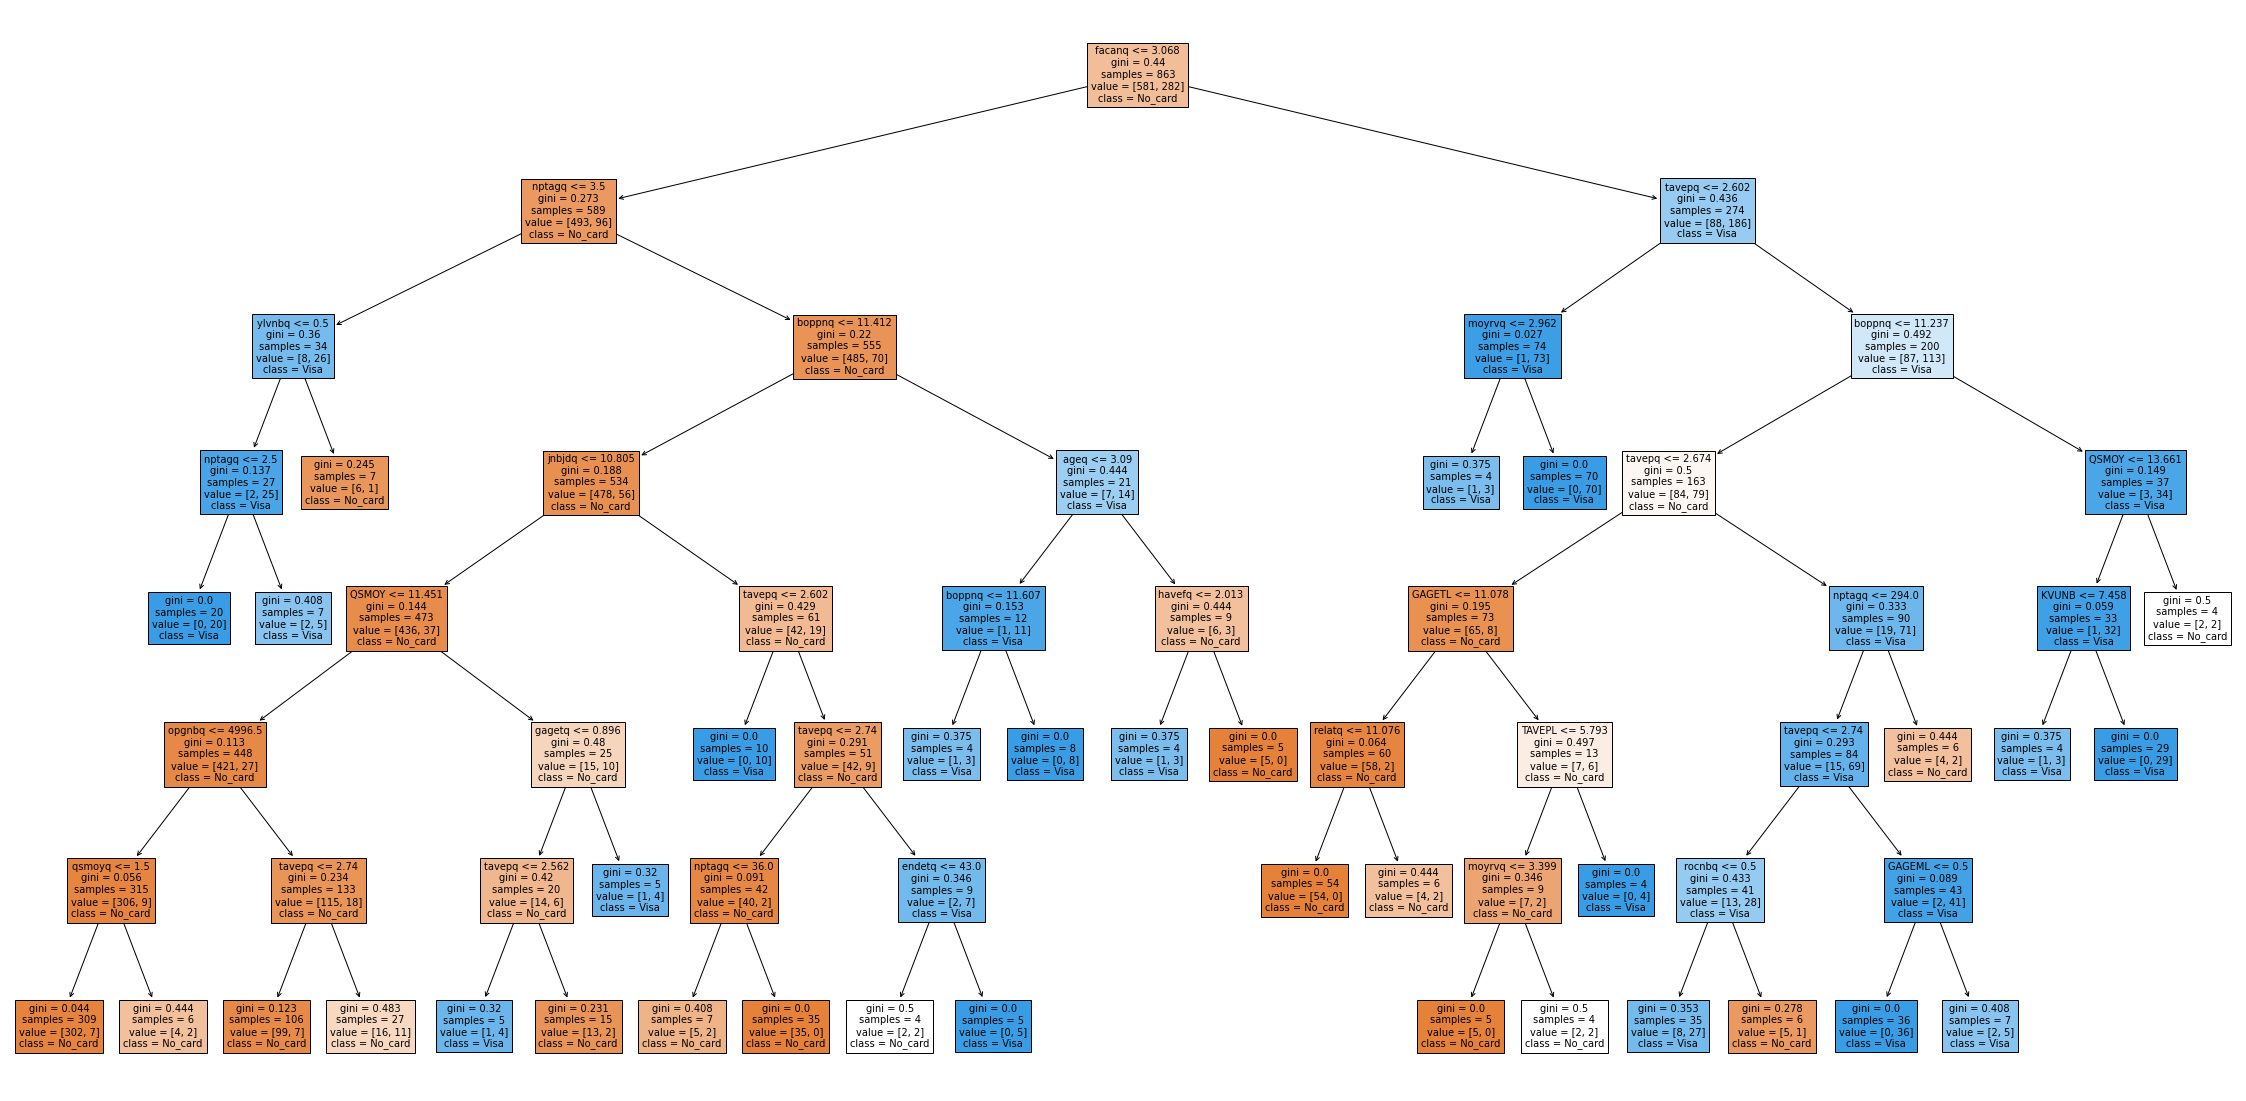

In [215]:
plt.figure(figsize=(40,20))
plot_tree(model_dtree[2], feature_names = X_train.columns,
               class_names=['No_card', 'Visa'],
               filled = True)
plt.savefig('treeOpt.png')

# Grid Search

In [192]:
grid_values = {'logisticregression__penalty': ['l1','l2'], 'logisticregression__C': [0.001,0.01,0.1,0.5, 1,5,10,100]}
#grid_values = {'randomforestclassifier__n_estimators': [50, 150, 250], 'randomforestclassifier__max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0], 'randomforestclassifier__min_samples_split': [2, 4, 6]}
grid_values = {"decisiontreeclassifier__max_depth":list(range(2,10)), "decisiontreeclassifier__min_samples_leaf" : list(range(1,5)), "decisiontreeclassifier__max_features" : list(range(1,40))}
model_gs = RandomizedSearchCV(pipeline, param_distributions=grid_values,cv=5, n_iter=50, scoring='f1')

In [193]:
model_gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this t

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('functiontransformer',
                                              FunctionTransformer(accept_sparse=False,
                                                                  check_inverse=True,
                                                                  func=<function _manage_columns at 0x7f87f8cb8268>,
                                                                  inv_kw_args=None,
                                                                  inverse_func=None,
                                                                  kw_args=None,
                                                                  validate=False)),
                                             ('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remaind

In [194]:
model_gs.best_params_

{'decisiontreeclassifier__max_depth': 7,
 'decisiontreeclassifier__max_features': 26,
 'decisiontreeclassifier__min_samples_leaf': 4}

In [221]:
df_results = pd.DataFrame(model_gs.cv_results_)
columns_to_keep = [
    'param_decisiontreeclassifier__max_depth',
    'param_decisiontreeclassifier__min_samples_leaf',
    'param_decisiontreeclassifier__max_features',
    'mean_test_score',
    'std_test_score',
]
df_results = df_results[columns_to_keep]
df_results.sort_values(by='mean_test_score', ascending=False).head(15)

param_decisiontreeclassifier__max_depth  ... std_test_score
18                                       7  ...       0.030835
3                                        6  ...       0.030603
9                                        5  ...       0.034707
16                                       8  ...       0.064743
10                                       9  ...       0.062033
40                                       3  ...       0.012135
48                                       7  ...       0.030863
39                                       4  ...       0.055522
5                                        9  ...       0.051907
45                                       7  ...       0.040243
14                                       9  ...       0.046888
11                                       9  ...       0.052082
19                                       5  ...       0.037064
7                                        6  ...       0.065052
49                                       6  ...       0.037205

[15 rows x 5 columns]

# Feature Importance

In [218]:
merger = model_rforest[0]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = model_rforest[1:]
predictor.fit(X_train_augmented, y_train).score(X_test_augmented, y_test)

0.9

In [219]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented, y_train, n_repeats=5
)

In [220]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [209]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_test_augmented, y_test, n_repeats=10
)

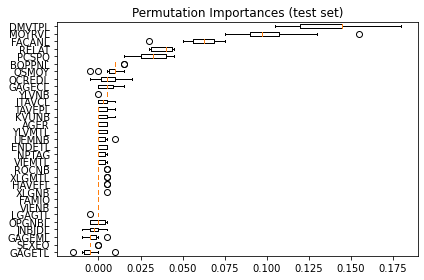

In [210]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_test_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()